In [109]:
import pandas as pd
import numpy as np
import sqlite3
import helper
import nltk
import string
import re
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.matutils import corpus2csc
from sklearn.feature_extraction.text import CountVectorizer

from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [52]:
db_path = '/Users/rustomichhaporia/Library/Messages/chat.db'
data_raw = helper.read_messages(db_path, n=None)

In [77]:
# Convert list of tuples to dataframe
df = pd.DataFrame.from_records(data_raw, columns =['row_id', 'body', 'phone_number', 'is_from_me', 'cache_roomname', 'group_chat_name', 'date'])
df = df.drop(['row_id'], axis=1)

# Pickle data for faster access later 
df.to_pickle('imessage.pkl')

In [87]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

text = df['body'].str.cat(sep=' ')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/rustomichhaporia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rustomichhaporia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [144]:
data = df['body']

def preprocess(text):
    tokens = nltk.word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha()]
    stopwords = nltk.corpus.stopwords.words('english')
    tokens = [token for token in tokens if token not in string.punctuation and token not in stopwords]
    url_pattern = r"(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?"
    tokens = [token for token in tokens if not re.match(url_pattern, token)]
    lemmatizer = nltk.stem.WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    if len(tokens) < 4:
        return None
    return tokens

data = data.apply(preprocess)

# tokens = nltk.word_tokenize(text)
# tokens = [word.lower() for word in tokens if word.isalpha()]
# stopwords = nltk.corpus.stopwords.words('english')
# tokens = [token for token in tokens if token not in string.punctuation and token not in stopwords]
# url_pattern = pattern = r"(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?"
# tokens = [token for token in tokens if not re.match(url_pattern, token)]

# fdist = nltk.FreqDist(tokens)
# filtered_tokens = [token for token in tokens if fdist[token] < fdist.N() * 0.05]

# lemmatizer = nltk.stem.WordNetLemmatizer()
# tokens = [lemmatizer.lemmatize(token) for token in tokens]

data = data.dropna()

In [ ]:
# Create a dictionary from the preprocessed data
dictionary = Dictionary(temp)

# Filter out words that appear in fewer than 5 documents or more than 50% of the documents
dictionary.filter_extremes(no_below=5, no_above=0.5)

bow_corpus = [dictionary.doc2bow(text) for text in data]

# Train the LDA model
num_topics = 5
ldamodel = LdaModel(bow_corpus, num_topics=num_topics, id2word=dictionary, passes=20, alpha='auto', eta='auto')

# Get the topics
topics = ldamodel.show_topics(num_topics=num_topics, num_words=10, log=False, formatted=False)

# Print the topics
for topic_id, topic in topics:
    print("Topic: {}".format(topic_id))
    print("Words: {}".format([word for word, _ in topic]))

Topic: 0
Words: ['okay', 'buy', 'yes', 'good', 'right', 'thank', 'next', 'need', 'god', 'day']
Topic: 1
Words: ['u', 'one', 'r', 'pick', 'want', 'home', 'time', 'make', 'fuck', 'come']
Topic: 2
Words: ['like', 'ok', 'think', 'get', 'sorry', 'know', 'even', 'would', 'let', 'tho']
Topic: 3
Words: ['ur', 'yeah', 'babe', 'paris', 'im', 'look', 'guy', 'bruh', 'hour', 'looking']
Topic: 4
Words: ['na', 'go', 'oh', 'lol', 'tower', 'gon', 'call', 'friend', 'wan', 'got']


In [161]:
temp = data[:100000]
# Create a dictionary from the preprocessed data
dictionary = Dictionary(temp)

# Filter out words that appear in fewer than 5 documents or more than 50% of the documents
dictionary.filter_extremes(no_below=5, no_above=0.001)

bow_corpus = [dictionary.doc2bow(text) for text in temp]

# Train the LDA model
num_topics = 15
ldamodel = LdaModel(bow_corpus, num_topics=num_topics, id2word=dictionary, passes=10, alpha='auto', eta='auto')

# Get the topics
topics = ldamodel.show_topics(num_topics=num_topics, num_words=12, log=False, formatted=False)

# Print the topics
for topic_id, topic in topics:
    print("Topic: {}".format(topic_id))
    print("Words: {}".format([word for word, _ in topic]))

Topic: 0
Words: ['waste', 'specific', 'grey', 'rate', 'mile', 'fri', 'related', 'turned', 'table', 'thurs', 'mexican', 'trading']
Topic: 1
Words: ['packing', 'stomach', 'san', 'applying', 'shop', 'block', 'score', 'excuse', 'carry', 'showing', 'egg', 'st']
Topic: 2
Words: ['totally', 'garage', 'pussy', 'doubt', 'speaker', 'teeth', 'search', 'pro', 'anniversary', 'alr', 'tn', 'fat']
Topic: 3
Words: ['letting', 'la', 'ny', 'oa', 'he', 'catch', 'mobile', 'mostly', 'service', 'dead', 'pulled', 'rock']
Topic: 4
Words: ['hotel', 'rich', 'current', 'clean', 'item', 'fucked', 'iphone', 'allowed', 'period', 'whether', 'havent', 'nose']
Topic: 5
Words: ['data', 'application', 'land', 'picked', 'diff', 'wife', 'reading', 'uh', 'mint', 'gay', 'program', 'leg']
Topic: 6
Words: ['paris', 'row', 'per', 'l', 'price', 'f', 'dick', 'e', 'mouth', 'tough', 'guitar', 'page']
Topic: 7
Words: ['pizza', 'parking', 'amazon', 'skill', 'wanting', 'worst', 'track', 'housing', 'soft', 'negotiate', 'driver', 'art']

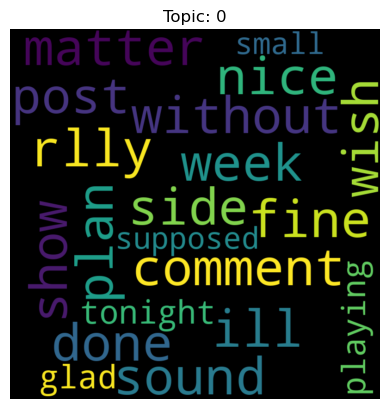

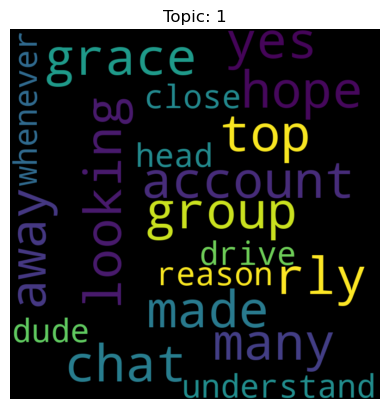

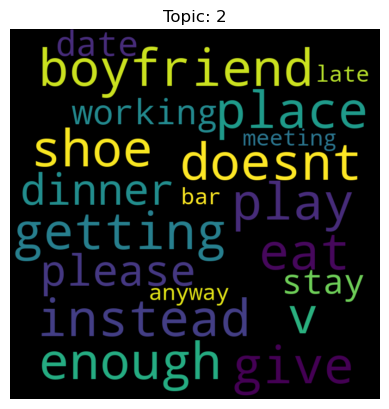

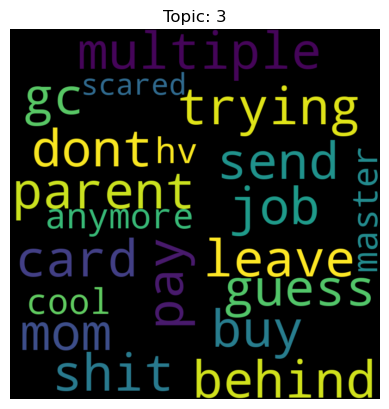

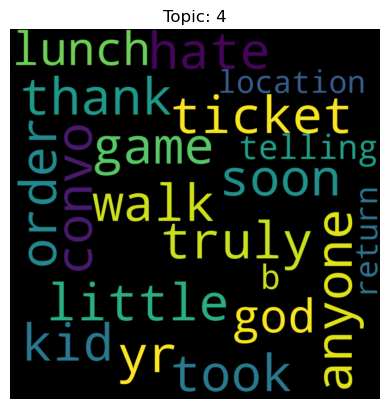

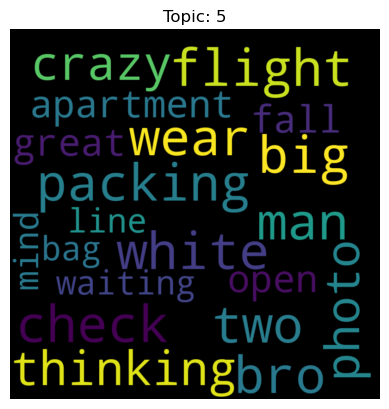

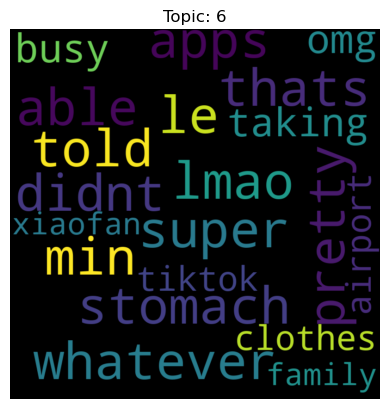

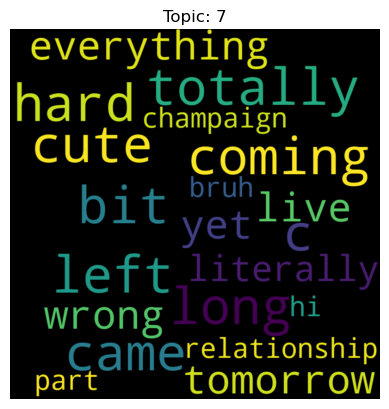

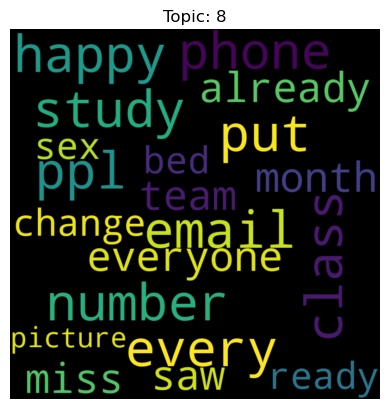

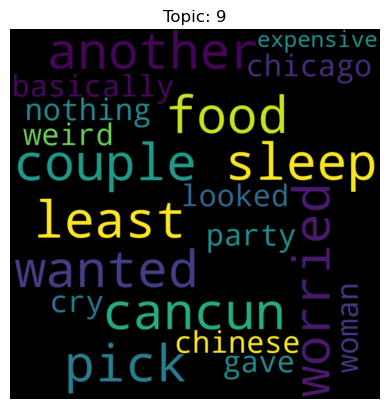

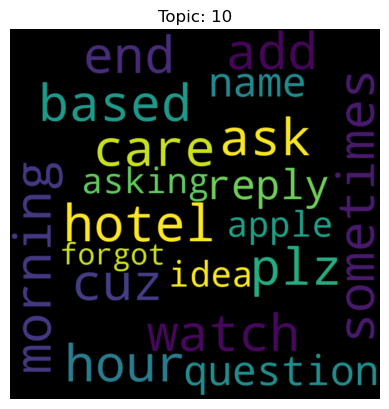

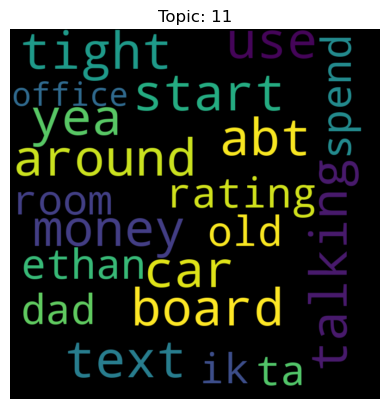

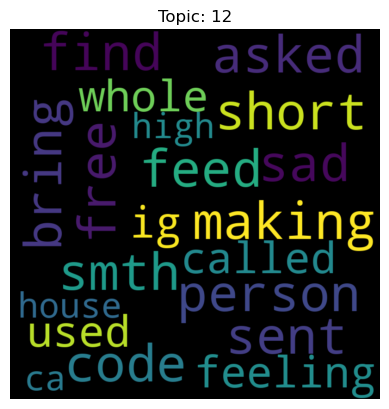

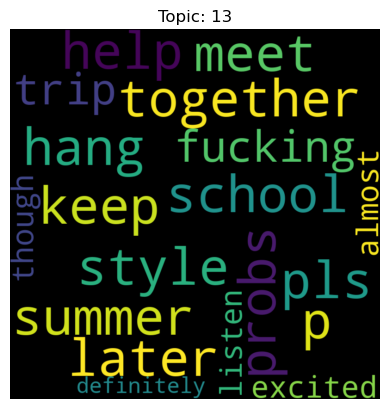

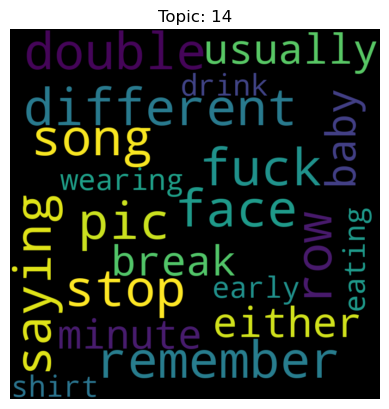

In [160]:
for topic_id, topic in enumerate(ldamodel.print_topics(num_topics=num_topics, num_words=20)):
    topic_words = " ".join([word.split("*")[1].strip() for word in topic[1].split(" + ")])
    wordcloud = WordCloud(width=800, height=800, random_state=21, max_font_size=110).generate(topic_words)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Topic: {}".format(topic_id))
    plt.show()

In [141]:
temp

0                                                      [hi]
1                                              [hey, cutie]
5                                                     [cum]
6                                                      [hi]
7                                                  [daniel]
                                ...                        
108063                            [im, ready, apply, cycle]
108064           [looking, ike, im, applying, like, school]
108065                                                [lma]
108066    [law, school, admission, kinda, fucked, rn, th...
108067    [cuz, scotus, decision, r, chasing, prompt, st...
Name: body, Length: 100000, dtype: object

In [147]:
temp = data.apply(lambda x: ' '.join(x))

In [148]:
bigtext = temp.str.cat(sep=' ')

In [149]:
from collections import Counter

counts = Counter(bigtext.split())

In [151]:
counts.most_common(200)

[('u', 8188),
 ('like', 6469),
 ('lol', 2909),
 ('think', 2488),
 ('na', 2392),
 ('ur', 2246),
 ('get', 2183),
 ('want', 2101),
 ('loved', 1860),
 ('one', 1827),
 ('go', 1818),
 ('know', 1699),
 ('time', 1679),
 ('feel', 1662),
 ('would', 1611),
 ('gon', 1532),
 ('yeah', 1517),
 ('bc', 1380),
 ('also', 1361),
 ('laughed', 1317),
 ('make', 1313),
 ('people', 1312),
 ('thing', 1295),
 ('friend', 1218),
 ('got', 1210),
 ('good', 1195),
 ('ok', 1136),
 ('guy', 1081),
 ('come', 1070),
 ('need', 1062),
 ('idk', 1057),
 ('see', 1026),
 ('say', 1022),
 ('day', 966),
 ('r', 956),
 ('back', 933),
 ('even', 924),
 ('im', 910),
 ('w', 910),
 ('much', 897),
 ('going', 896),
 ('really', 890),
 ('let', 869),
 ('lot', 868),
 ('wan', 863),
 ('still', 857),
 ('liked', 801),
 ('said', 793),
 ('take', 792),
 ('something', 751),
 ('actually', 749),
 ('rn', 743),
 ('maybe', 734),
 ('tho', 732),
 ('ayan', 726),
 ('look', 723),
 ('probably', 701),
 ('love', 697),
 ('today', 671),
 ('work', 653),
 ('wait', 631

In [130]:
bigtext[1]

'i'

In [126]:
temp

0                                     hi
1                              hey cutie
5                                    cum
6                                     hi
7                                 daniel
                       ...              
127305                            oh god
127306                 cant even imagine
127307                          u friend
127308                              yeah
127309    ill probs go home hour two tho
Name: body, Length: 118018, dtype: object

In [122]:
text = data.str.cat(sep=' ')

TypeError: Cannot use .str.cat with values of inferred dtype 'mixed'.

In [110]:
dictionary = Dictionary([tokens])


In [112]:
bow_corpus = [dictionary.doc2bow(text) for text in tokens]
num_topics = 5
ldamodel = LdaModel(bow_corpus, num_topics=num_topics, id2word=dictionary, passes=20, alpha='auto', eta='auto')

# Get the topics
topics = ldamodel.show_topics(num_topics=num_topics, num_words=10, log=False, formatted=False)

# Print the topics
for topic_id, topic in topics:
    print("Topic: {}".format(topic_id))
    print("Words: {}".format([word for word, _ in topic]))

TypeError: doc2bow expects an array of unicode tokens on input, not a single string

In [82]:
len(text)

4184261

In [72]:
text

0                                                       H i
1                                     h e y   c u t i e   😉
2                                                         ￼
3                                                         ￼
4                                                         ￼
                                ...                        
127305                                          o h   g o d
127306      i   c a n t   e v e n   i m a g i n e   t h a t
127307    a r e   u   w i t h   y o u r   f r i e n d s ...
127308                                              y e a h
127309    i l l   p r o b s   g o   h o m e   i n   a n ...
Name: body, Length: 127310, dtype: object

In [60]:
# df.groupby('phone_number').filter(lambda x: len(x) > 100)

In [57]:
df.group_chat_name.value_counts()

                          103735
illinois labs 1.5           4327
Core 3 + camera man         4327
shrey’s therapy group       2781
cancunt🪇                    2766
deeya fan club              1978
my baby                     1399
DOWN                        1044
core four 🫡                  962
Gas Works Gang               679
babe                         621
Fella                        545
(MS Energy).length - 1       423
the goons                    396
Double Trouble               372
bowleing                     260
nascar 🚗                     204
Core four                    148
Dinner                        81
Phade Studios                 80
last men standing             73
Thing 1 & Thing 2             33
Foodies: Afterhourz            5
Name: group_chat_name, dtype: int64